# Competition: Modulation format classification

#### Solution using simple binary classification based on quadrature energies (implemented in PyTorch)

Enter your team name here:

In [2]:
# Bevore you start, please enter your team name!
team_name = 'REFERENCE_PyTorch_Classification'

The main code starts here...

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [3]:
# In case you want to use PyTorch to build you classifier
import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


Helper code that computes the the classification error rate, i.e. $\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y})$, an estimate of the error probability. The classification is obtained from $N$ pairs $(\boldsymbol{x}_i, y_i)$, $i=1,\ldots, N$ and the corresponding estimates $\hat{y}_i = f(\boldsymbol{x}_i)$ as follows
$$
\hat{P}(\hat{\mathsf{y}} \neq \mathsf{y}) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{\{f(\boldsymbol{x}_i) \neq y_i\}}
$$
where $\mathbb{1}_{\{E\}}$ is the indicator function, which returns 1 if the event $E$ is true and 0 otherwise

In [4]:
# helper function to compute the classification error rate.
def CER(predictions, labels):
    """Calculates the classification error rate."""
    return (np.sum(predictions != labels) / len(predictions))

This is a helper function that double-checks if the data is correct and carries out some sanity-checks.

In [1]:
# Checks if the data you upload has the correct type/form
def check_predictions(test_data, predictions, valid_values):
    """Chcecks if predicitions has the right length and type."""
    if isinstance(predictions,np.ndarray):
        print('type ok.')
    else:
        raise Exception('wrong type, predictions should be of type np.ndarray')
    if predictions.ndim != 1:
        raise Exception('wrong dimension, predictions must have dim 1')
    else:
        print('dim ok.')
    if len(test_data) != len(predictions):
        raise Exception('wrong length, "X_test" and "predictions" must have the same length.')
    else:
        print('length ok.')
    all_values_valid = True
    for i in range(len(predictions)):
        if (predictions[i] not in valid_values):
            print('All values of "predictions" have to be in "valid data".')
            all_values_valid = False
            break
    if all_values_valid:
        print('Predictions are valid values.')

## Task 1: Distinguish between BPSK and QPSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. 

Show the classification error for the validation set for each SNR point separately.

Load datasets. They are stored as a pickle file.

The dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

In [7]:
# Download data sets if they are not available
from os.path import exists
import urllib.request
    
if not exists('MLOC_Competition_2023_task1_dataset_train.pkl'):
    print('Downloading data set file 1/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_train.pkl', 'MLOC_Competition_2023_task1_dataset_train.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_dataset_valid.pkl'):
    print('Downloading data set file 2/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_dataset_valid.pkl', 'MLOC_Competition_2023_task1_dataset_valid.pkl')        
    print('done')

if not exists('MLOC_Competition_2023_task1_test_data.pkl'):
    print('Downloading data set file 3/3, please wait ... ', end='')
    urllib.request.urlretrieve('https://bwsyncandshare.kit.edu/s/wZ4f3r4eLGApPHY/download?files=MLOC_Competition_2023_task1_test_data.pkl', 'MLOC_Competition_2023_task1_test_data.pkl')        
    print('done')

In [8]:
# Load training dataset
with open('MLOC_Competition_2023_task1_dataset_train.pkl', "rb") as f:
    X_train_task_1 = pickle.load(f)
    y_train_task_1 = pickle.load(f)
    SNR_train_task_1 = pickle.load(f)
    modulation_formats_task_1 = pickle.load(f)
    SNRs_task_1 = pickle.load(f)
    
# Load validation dataset
with open('MLOC_Competition_2023_task1_dataset_valid.pkl', "rb") as f:
    X_valid_task_1 = pickle.load(f)
    y_valid_task_1 = pickle.load(f)
    SNR_valid_task_1 = pickle.load(f) 
    
# Load test data
with open('MLOC_Competition_2023_task1_test_data.pkl', "rb") as f:
    X_test_task_1 = pickle.load(f)

Print modulation formats ans SNR values which are used:

In [9]:
print('Modulation formats: ', modulation_formats_task_1)
print('SNR values: ', SNRs_task_1)

Modulation formats:  ['BPSK', 'QPSK']
SNR values:  [-10  -8  -6  -4  -2   0   2   4]


Plot 6 random signal traces

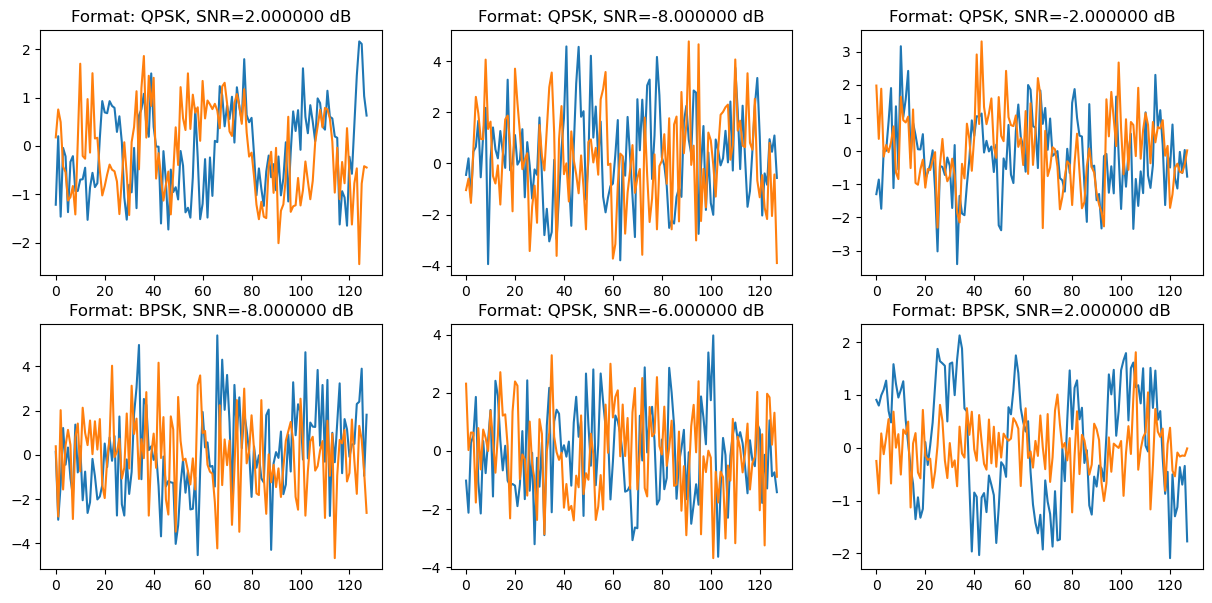

In [10]:
starti = np.random.randint(0,X_train_task_1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task_1[k+starti,:]))
    plt.plot(np.imag(X_train_task_1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats_task_1[y_train_task_1[k+starti]], SNR_train_task_1[k+starti]))    

Prepare the data and convert everything to PyTorch tensors

In [11]:
# prepare data, convert complex data to real and imaginary parts
X_train_task_1_real = np.column_stack((np.real(X_train_task_1), np.imag(X_train_task_1)))
X_valid_task_1_real = np.column_stack((np.real(X_valid_task_1), np.imag(X_valid_task_1)))

# prepare data, generate feature vector X consisting of energy of real part and energy of imaginary part
X_train_feature = np.column_stack( (np.sum(np.square(np.real(X_train_task_1)),1), np.sum(np.square(np.imag(X_train_task_1)),1)) )
X_valid_feature = np.column_stack( (np.sum(np.square(np.real(X_valid_task_1)),1), np.sum(np.square(np.imag(X_valid_task_1)),1)) )


# Prepare the data, convert to PyTorch data structure and move to GPU (if available)
X_train_torch = torch.Tensor(X_train_feature).to(device)
X_valid_torch = torch.Tensor(X_valid_feature).to(device)


y_train_torch = torch.Tensor(y_train_task_1).to(device)
y_valid_torch = torch.Tensor(y_valid_task_1).to(device)

#### Solution using learned binary classification

Here, we employ a binary classification to carry out the classification between BPSK and QPSK, similarly to what we have seen in the lecture for BPSK detection.

We define a feature vector $\boldsymbol{x} \in \mathbb{R}^2$ that contains the energy in the real and imaginary part of the signal trace:
\begin{equation*}
 \boldsymbol{x} = \begin{pmatrix}
 \sum_{i=1}^N (\mathrm{Re}\{r_i\})^2 \\ \sum_{i=1}^N (\mathrm{Im}\{r_i\})^2
 \end{pmatrix}
\end{equation*}

We use binary classification and define the probability $P(Y = 1 |\boldsymbol{\theta}, \boldsymbol{x}) = \sigma(\boldsymbol{\theta}^\top\boldsymbol{x})$.

If $P(Y = 1 |\boldsymbol{\theta}, \boldsymbol{x}) > \frac{1}{2}$, we decide for $Y = 1$ (QPSK).

The weight vector $\boldsymbol{\theta}$ is obtained as detailed in the lecture.

We implement the classifier in PyTorch. In order to avoid numerical instabilities, we should not directly implement the sigmoid function in the learning rule, but use the `BCEWithLogitsLoss`, which directly integrates the sigmoid function (see help page).

Below is the classifier implemented in PyTorch (without sigmoid)

In [12]:
# Define Classifier
class Classifier_Task_1(nn.Module):
    def __init__(self):
        super(Classifier_Task_1, self).__init__()
        # Linear layer, i.e., multiplication with a matrix of size 2x1, no bias
        self.fc1 = nn.Linear(2, 1, bias=False)            
        
    def forward(self, x):                
        # sigmoid ( theta^T * x)
        # do not put the sigmoid here for stability reasons, it is better to have it inside the loss function
        out = self.fc1 ( x )
        return out

# Binary Cross Entropy loss function
loss_fn = nn.BCEWithLogitsLoss()
sigmoid = nn.Sigmoid()

Implement the training of the model. We reuse the data 500 times, and each time is an epoch. The plain gradient descent optimizer optimizer with a learning rate of $10^{-2}$ is used.

In [13]:
### possible solution here ###

num_epochs = 500

model = Classifier_Task_1()

# initialize weights of linear layer to zero
with torch.no_grad():
    model.fc1.weight.zero_()

model.to(device)


# Gradient Descent Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Start Training
print('Train over all SNRs')
validation_CERs = np.zeros(num_epochs)

for epoch in range(num_epochs):      
    # Send data trough net
    outputs = model(X_train_torch)
    
    # compute loss
    loss = loss_fn(outputs.squeeze(), y_train_torch.squeeze())

    # compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # reset gradients
    optimizer.zero_grad()

    if epoch % 100 == 0:
        out_valid = sigmoid(model(X_valid_torch)) > 0.5
        validation_CERs[epoch] = CER(out_valid.detach().cpu().numpy().squeeze(), y_valid_task_1)
        print('Validation CER after epoch %d: %f (loss %1.8f)' % (epoch, validation_CERs[epoch], loss.detach().cpu().numpy()))        

print(model.fc1.weight)

Train over all SNRs
Validation CER after epoch 0: 0.259344 (loss 0.69314718)
Validation CER after epoch 100: 0.273656 (loss 45.64807892)
Validation CER after epoch 200: 0.272992 (loss 45.44984818)
Validation CER after epoch 300: 0.272992 (loss 45.44944763)
Validation CER after epoch 400: 0.272992 (loss 45.44944763)
Parameter containing:
tensor([[-2.8651,  4.1168]], device='cuda:0', requires_grad=True)


Implement the classifier using the trained model. Therefore, first convert the data to a PyTorch tensor and then apply the model

In [14]:
print("Example:")
idx = 12
print("Feature vector: ", X_train_feature[idx,:])
print("Corresponds to %s at an SNR of %1.2f dB" % (modulation_formats_task_1[y_train_task_1[idx]], SNR_train_task_1[idx]))
print("Output of estimator: P(Y = 1|\\theta, x) = %1.2f" % sigmoid(model(X_train_torch[idx,:])))

Example:
Feature vector:  [761.4011 691.1356]
Corresponds to QPSK at an SNR of -10.00 dB
Output of estimator: P(Y = 1|\theta, x) = 1.00


In [15]:
# This is the final classified using the learned weights
def BPSK_QPSK(data):     
    # compute the power of I and Q components
    power_I = np.sum(np.square(np.real(data.squeeze())), axis=1)
    power_Q = np.sum(np.square(np.imag(data.squeeze())), axis=1)

    data_torch = torch.Tensor(np.column_stack((power_I,power_Q))).to(device)
    
    # Use the weights obtained earlier, remember to apply the sigmoid function (would not be really necessary, just for completeness)    
    classification = sigmoid(model(data_torch)).squeeze().detach().cpu().numpy() > 0.5    
    return classification

In [16]:
# Validate results
idx_SNR_valid = []
for i in range(len(SNRs_task_1)):
    idx_SNR_valid.append(np.asarray(np.where(SNR_valid_task_1 == SNRs_task_1[i])))    

error_rates_single_SNR = np.empty([len(SNRs_task_1)])
for SNR in range(len(SNRs_task_1)):   
    # Get data coresponding to the SNR value
    X_valid_single_SNR = X_valid_task_1[idx_SNR_valid[SNR]]
    y_valid_single_SNR = y_valid_task_1[idx_SNR_valid[SNR]]    
    
    yh = BPSK_QPSK(X_valid_single_SNR)    
    error_rates_single_SNR[SNR] = CER(yh, y_valid_single_SNR)    

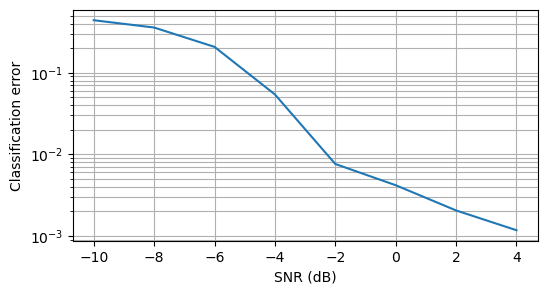

In [17]:
# Plot Results    
plt.figure(figsize=(6,3))
plt.semilogy(SNRs_task_1, error_rates_single_SNR)
plt.xlabel('SNR (dB)')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.savefig('Example_result.pdf',bbox_inches='tight')

In [18]:
# Send test data through the classifier
predictions_task_1 = BPSK_QPSK(X_test_task_1)


# Write predictions to file including sanity check
### Don't touch this part
check_predictions(X_test_task_1, predictions_task_1, range(len(modulation_formats_task_1)))

with open('Task_1_%s.pkl' % team_name,'wb') as f:
    pickle.dump(predictions_task_1,f)

type ok.
dim ok.
length ok.
Predictions are valid values.
